# Exercise 3

_**Materials:**_

_`\dunnhumby - Breakfast at the Frat.xlsx"` provided in Handout 4._

_**Objective:**_

_On the product (UPC) level predict future sales from the sales history._

Note: File is expected to be in same directory as this notebook (assignment is delivered with this structure).

In [203]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy.stats import binom_test
from pprint import pprint
from fbprophet import Prophet
import numpy as np
import itertools
from tqdm import tqdm_notebook
import utils
from multiprocessing.pool import ThreadPool, Pool
import psutil
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from decimal import Decimal
from sklearn.feature_selection import mutual_info_regression

# Suppress numpy warnings for cleaner log.
np.warnings.filterwarnings('ignore')

# Read/pre-process data.
products: pd.DataFrame = pd.read_csv("data_products_lookup.csv", index_col="UPC")
products["extended_description"] = products["DESCRIPTION"] + " (" + products.index.astype(str) + ")"
stores: pd.DataFrame = pd.read_csv("data_store_lookup.csv", index_col="STORE_ID")
if not os.path.isfile("transactions.pkl"):
    transactions: pd.DataFrame = pd.read_csv("data_transactions.csv")
    transactions.WEEK_END_DATE = pd.to_datetime(transactions.WEEK_END_DATE, infer_datetime_format=True)
    transactions.to_pickle("transactions.pkl")
else:
    transactions: pd.DataFrame = pd.read_pickle("transactions.pkl")

## 1. Time Series Analysis

_**1**. Choose 5 top products (with best total sales). Verify that these products
have been sold during the last 4 weeks. Use the products-lookup sheet to
find out information about the selected products._

Note: We assume "total sales" to refer to the column `SPEND`.

In [204]:
# Ensure only to consider products having been bought during the most recent 4 weeks in timespan covered in
# records.
valid_product_ids = transactions.groupby("UPC")[["WEEK_END_DATE"]].max()
valid_product_ids = set(
    valid_product_ids[
        valid_product_ids.WEEK_END_DATE >= transactions.max()["WEEK_END_DATE"] - pd.Timedelta(4, unit='w')
    ].index.values
)
valid_transactions = transactions[transactions.UPC.isin(valid_product_ids)]

by_sales = valid_transactions[["UPC", "SPEND"]].groupby("UPC").sum().sort_values("SPEND", ascending=False)
top5_prods_by_sales = by_sales.head(5).join(products)

top5_prods_by_sales

,SPEND,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE,extended_description
UPC,,,,,,,
1600027527,2048896.22,GM HONEY NUT CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ,GM HONEY NUT CHEERIOS (1600027527)
3800031838,1483799.52,KELL FROSTED FLAKES,KELLOGG,COLD CEREAL,KIDS CEREAL,15 OZ,KELL FROSTED FLAKES (3800031838)
7192100339,1437337.39,DIGRN PEPP PIZZA,TOMBSTONE,FROZEN PIZZA,PIZZA/PREMIUM,28.3 OZ,DIGRN PEPP PIZZA (7192100339)
1600027528,1433001.72,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,18 OZ,GM CHEERIOS (1600027528)
1600027564,1384585.78,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,GM CHEERIOS (1600027564)


_**2**. Plot a graph of the total weekly number of units sold for the chosen 5
products. Are there products for which you can detect a trend or a seasonal behavior?_
_Remark: be aware that data is originally organized on the granularity level:
(product, household) and you are interested in total sales per product._

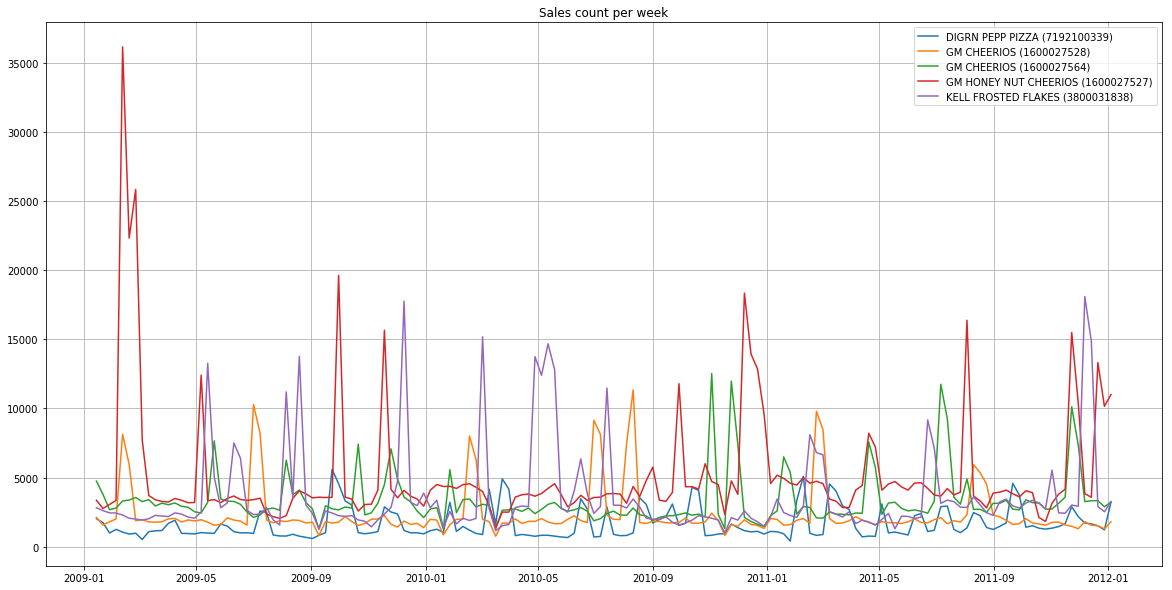

In [205]:
utils.plot_salescount_per_week(transactions, products, set(top5_prods_by_sales.index.values), "Sales count per week")
plt.grid()

_**3**. Investigate the influence of promotions on the number of products sold. 
There are 3 promotion types: `FEATURE` (product was a part of instore promotional display), `DISPLAY` (product was in in-store circular), `TPR ONLY` (temporary price reduction only (i.e., shelf tag only, product was reduced in price but not on display or in an advertisement). Which promotion types seems to have the most influence on the number of products sold? Support your answer by adding vertical lines on your plot for the dates when the chosen promotion happened._

To answer the question whether promotions do make a difference, we propose a binomial test with $H_0$ -> promotions do not make a difference. We hence proceed to apply a binomial test with $p = 0.5$ for each promotion type:

In [206]:
for column in ("FEATURE", "DISPLAY", "TPR_ONLY"):
    contingency_table_units = transactions[["UNITS"]].groupby(transactions[column]).mean()
    print(
        column + ":",
        str(
            binom_test(
                contingency_table_units.loc[0].UNITS,
                n=contingency_table_units.UNITS.sum(),
                p=0.5,
                alternative='greater'
            )
        )
    )

FEATURE: 0.9999949519363245
DISPLAY: 0.9999558122183622
TPR_ONLY: 0.49999999999999967


We can hence reject $H_0$ - that promotions don't make a difference. Furthermore we plot, for each product/UPC and promotion type, the occurences of promotions (each red striped line marks a day where this product was sold with a promotion):

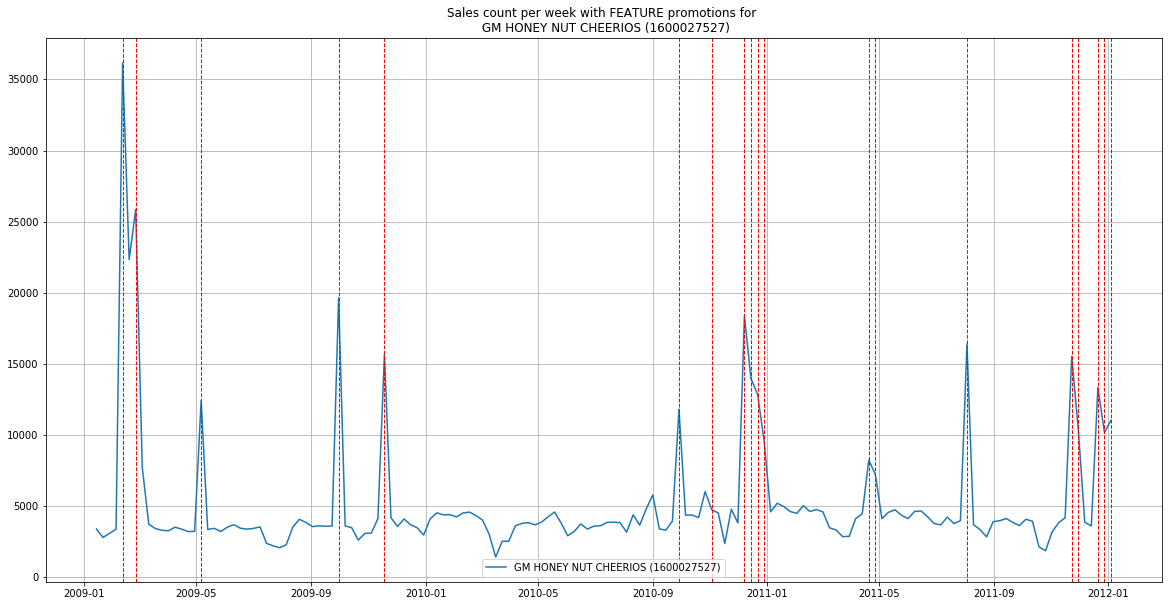

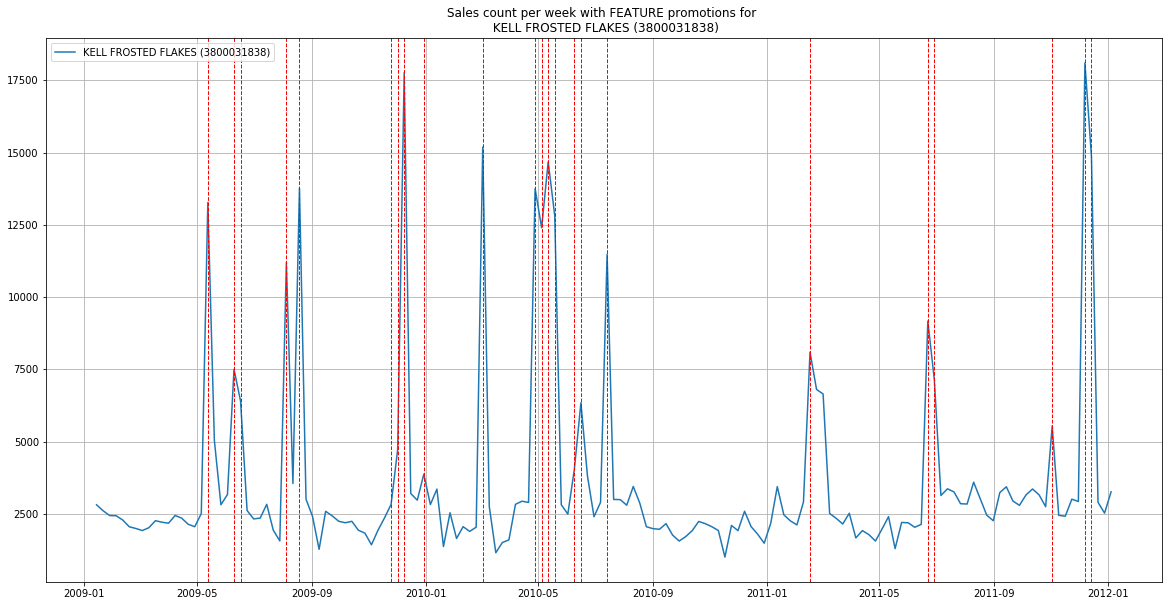

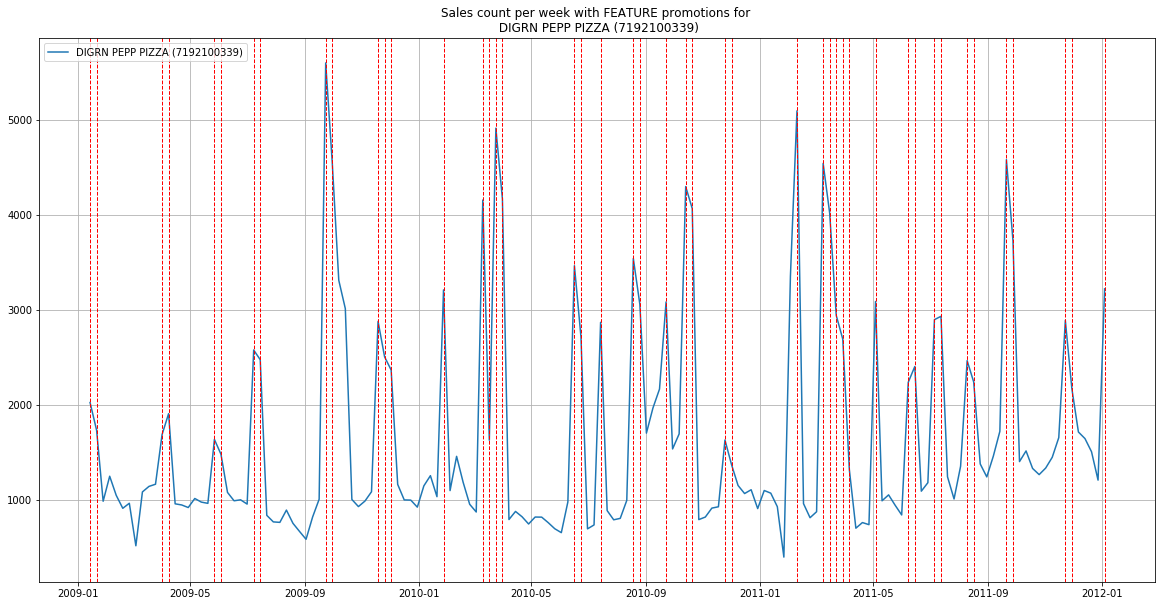

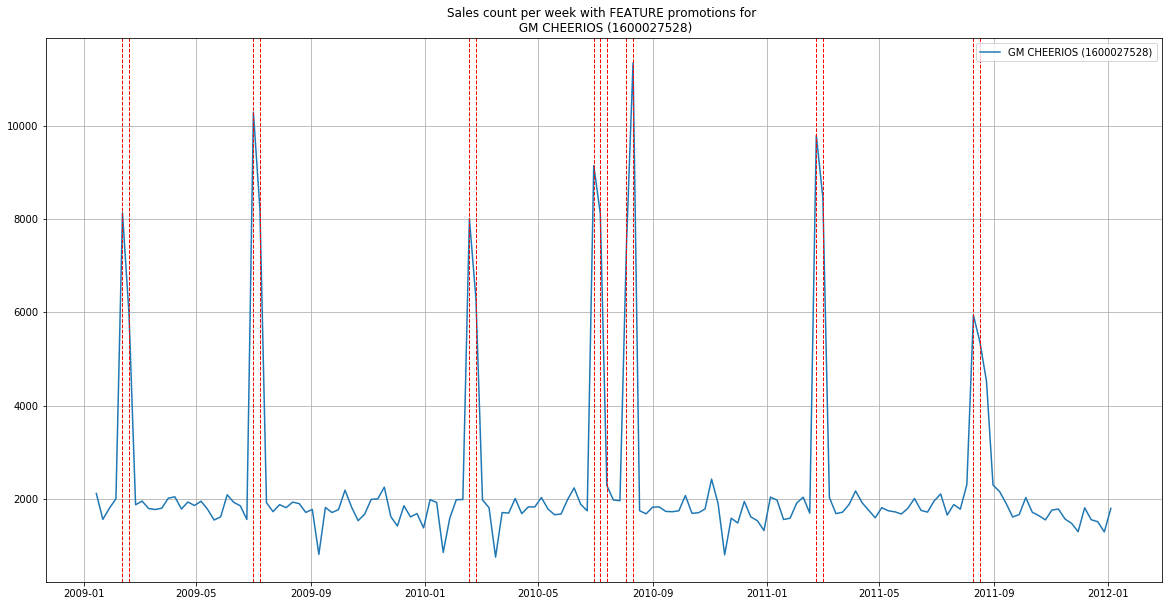

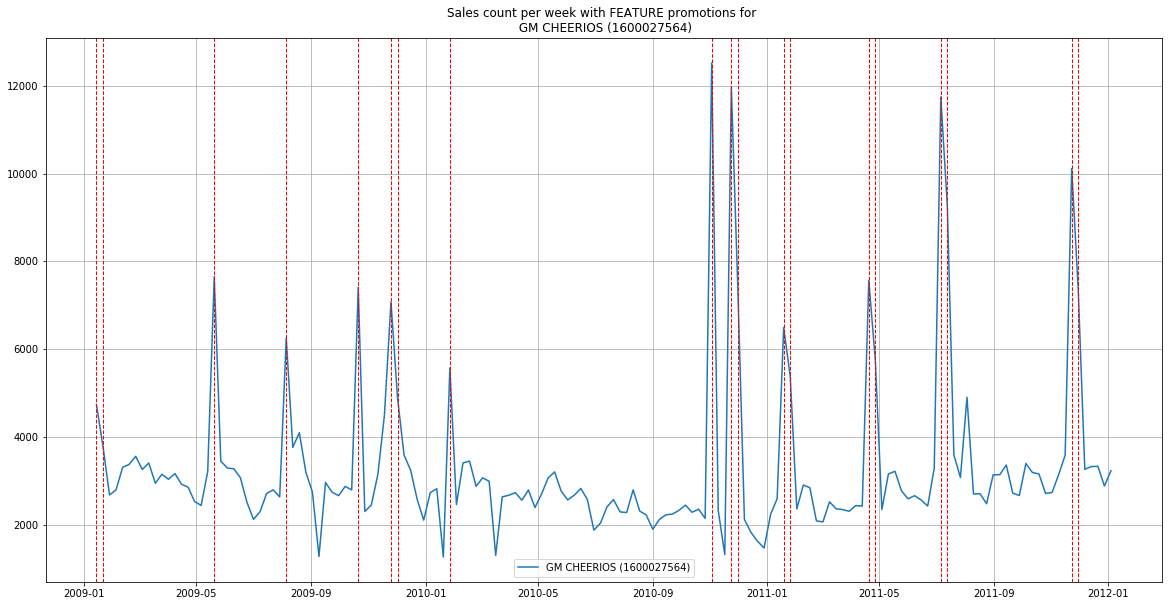

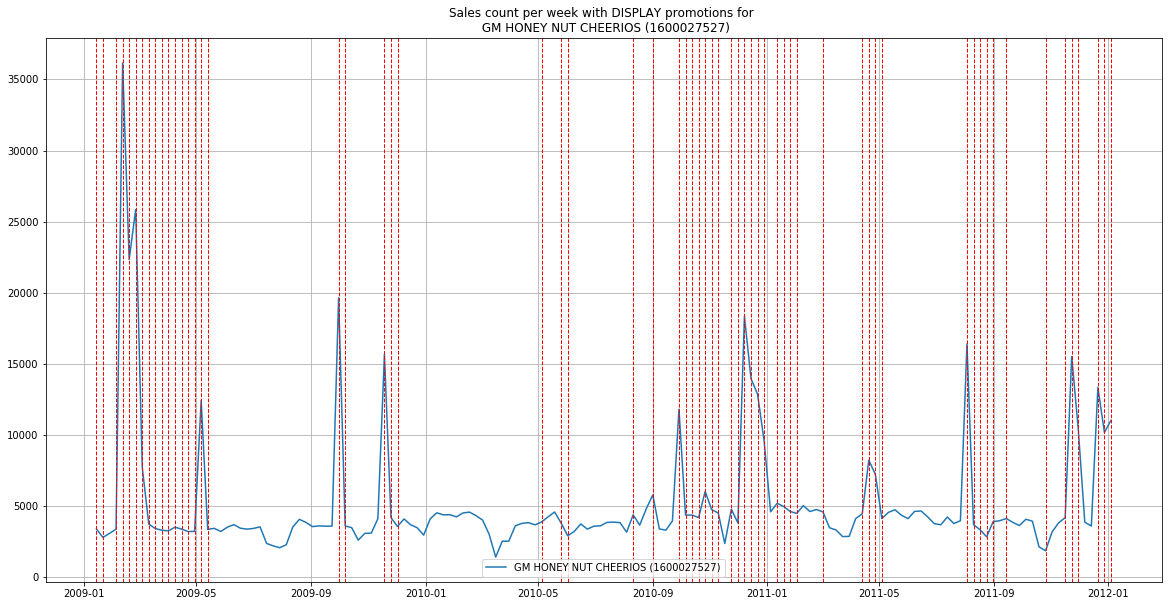

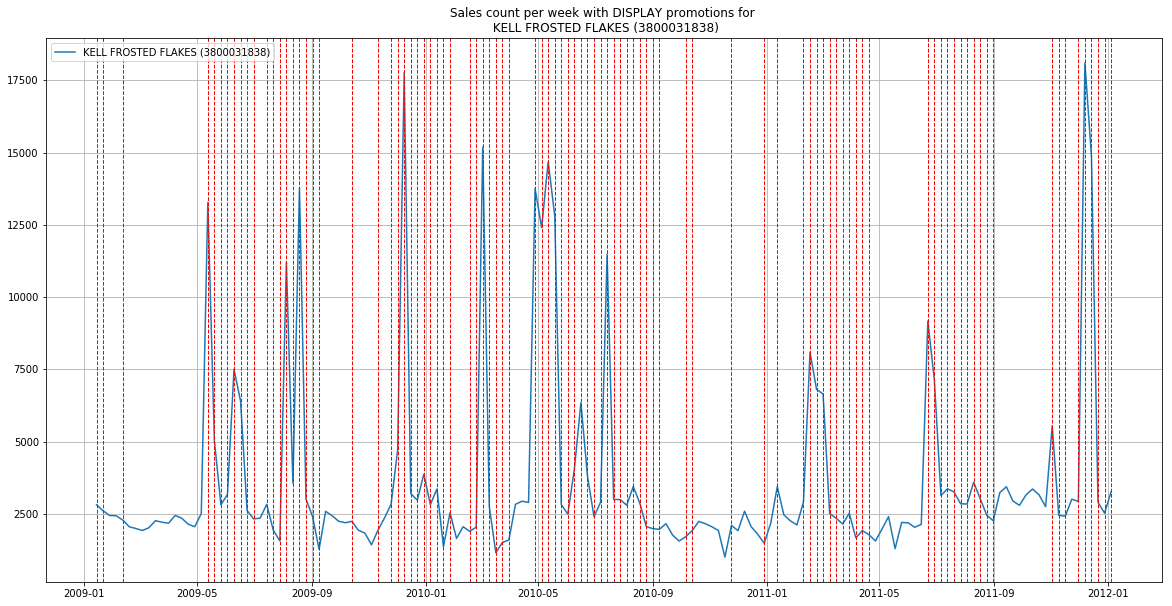

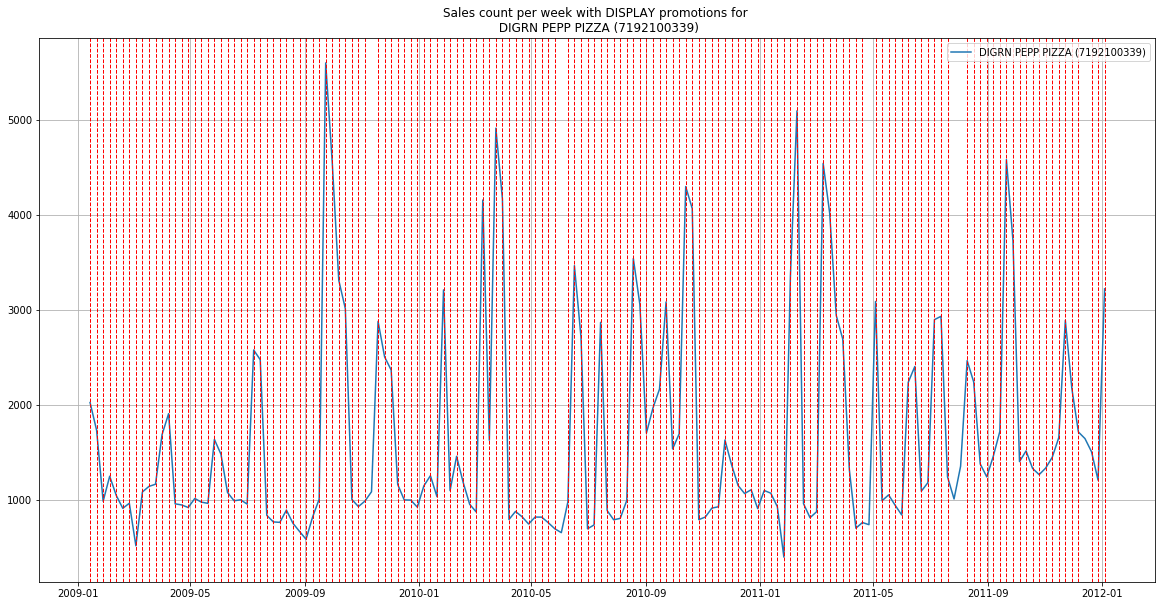

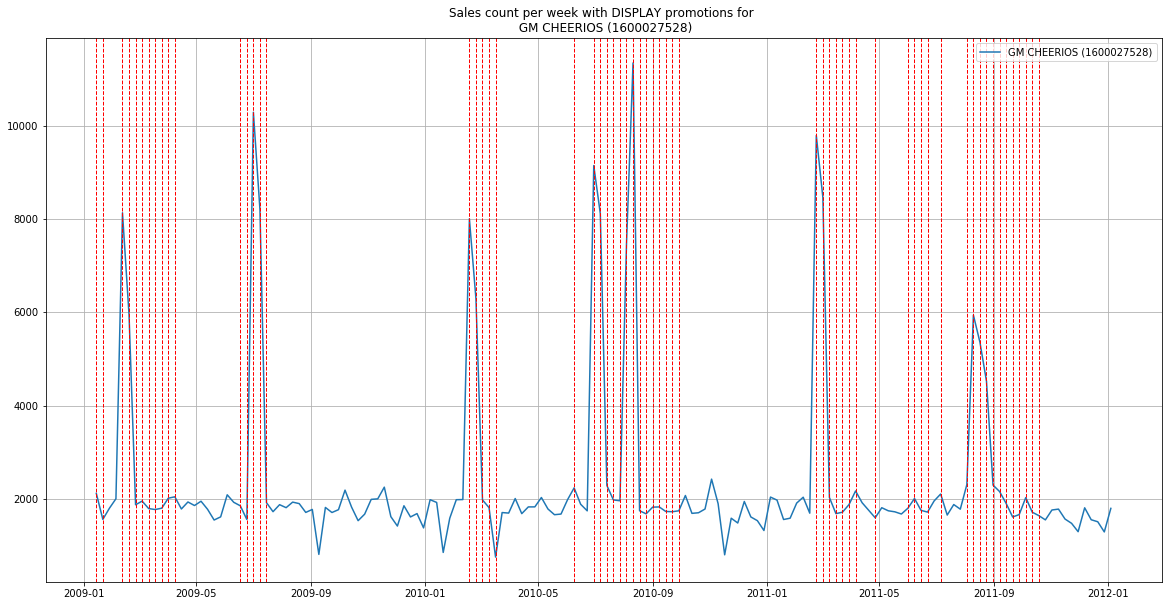

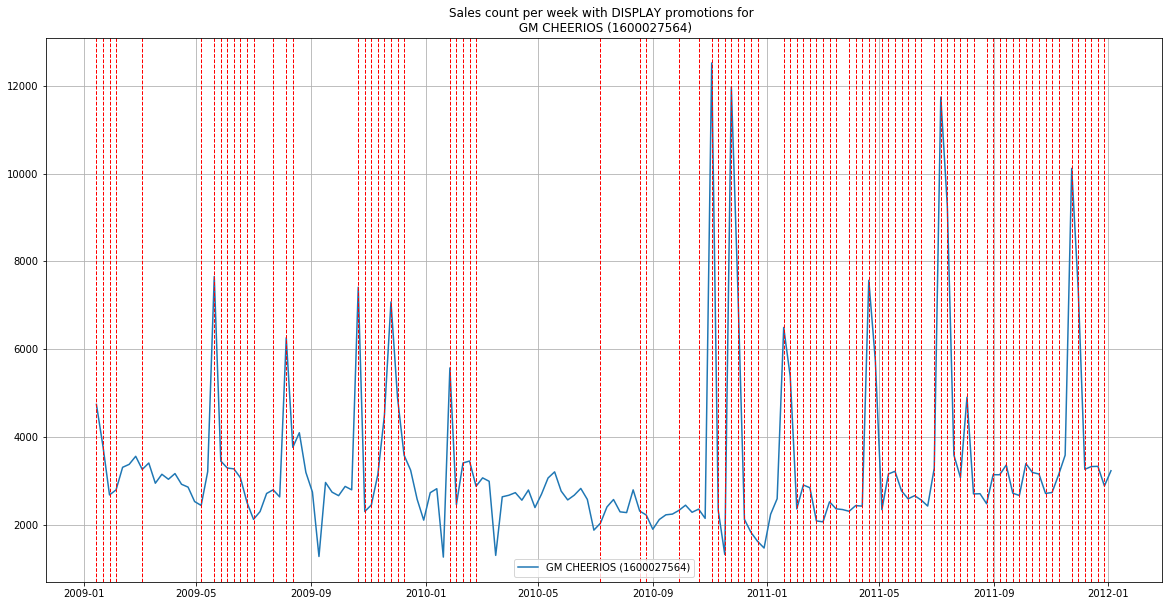

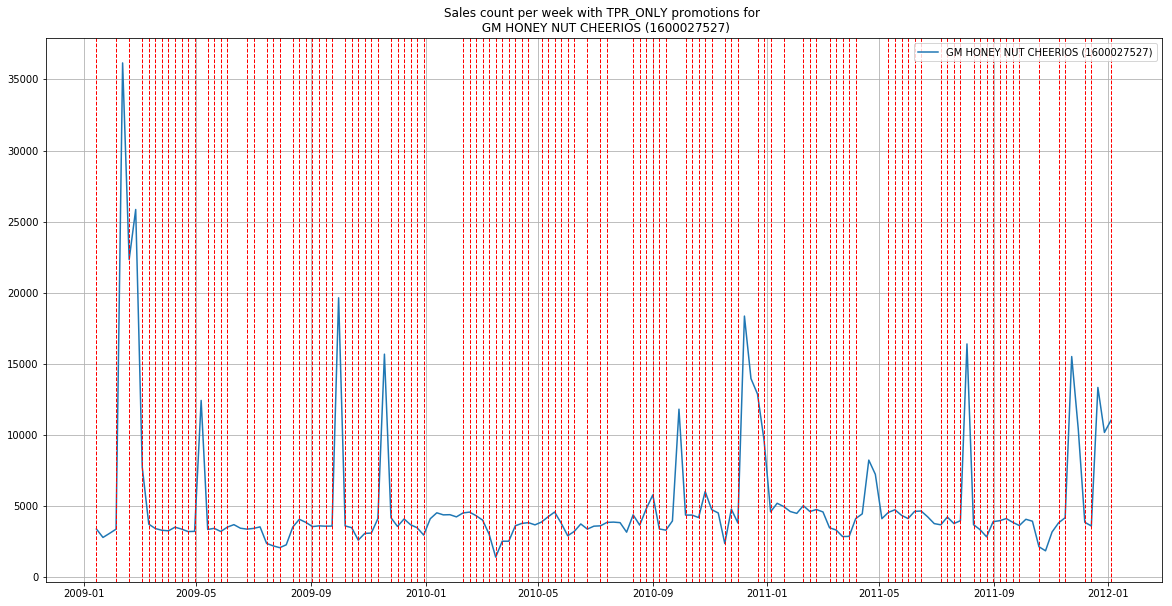

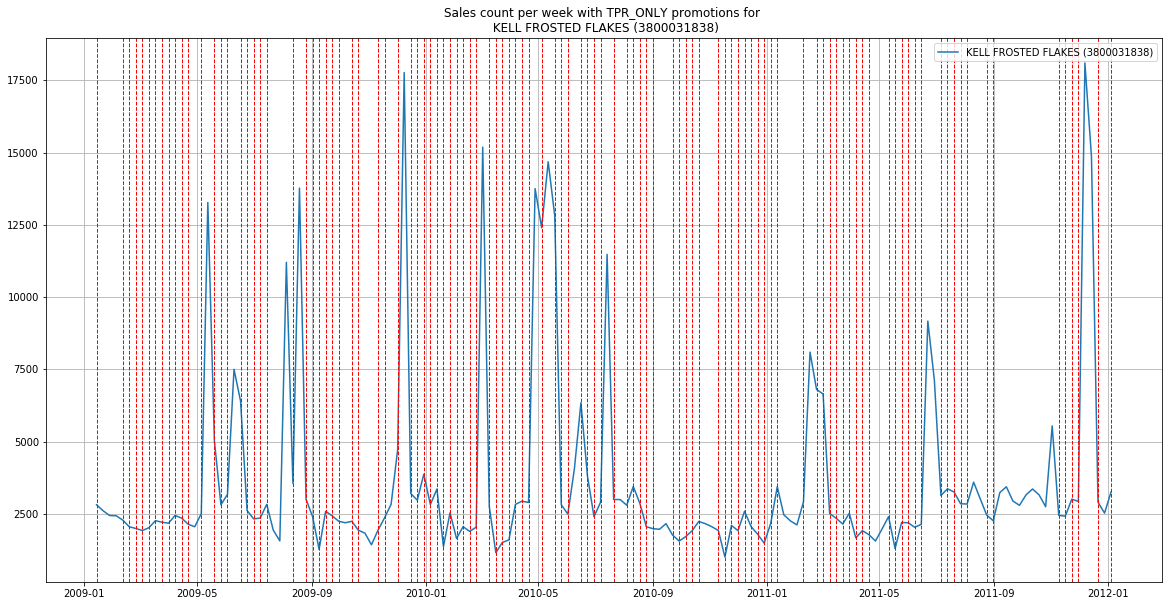

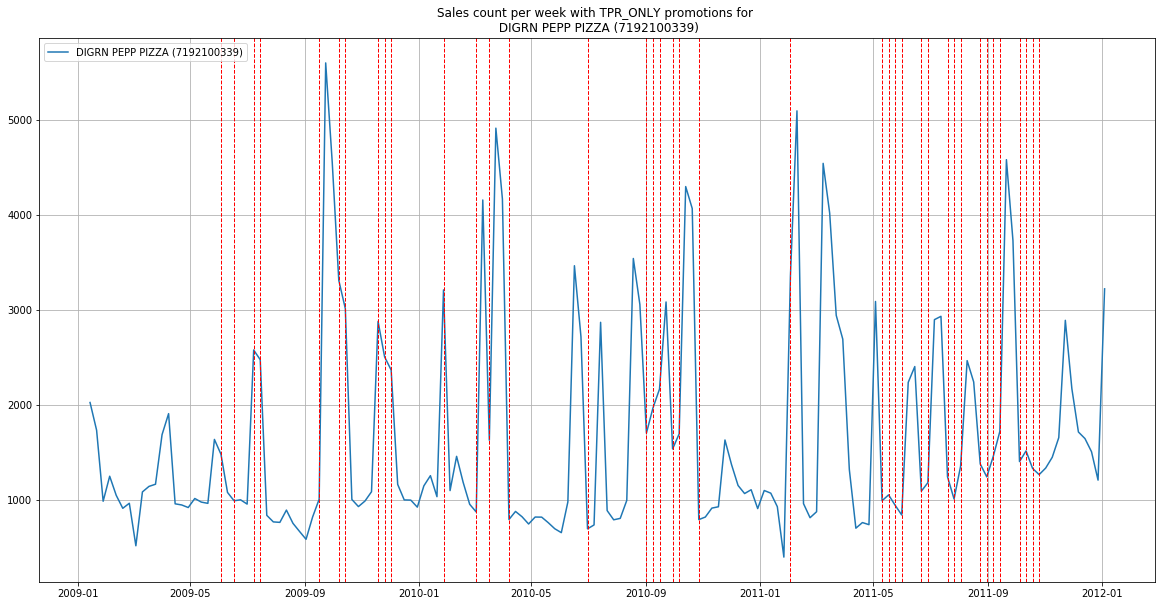

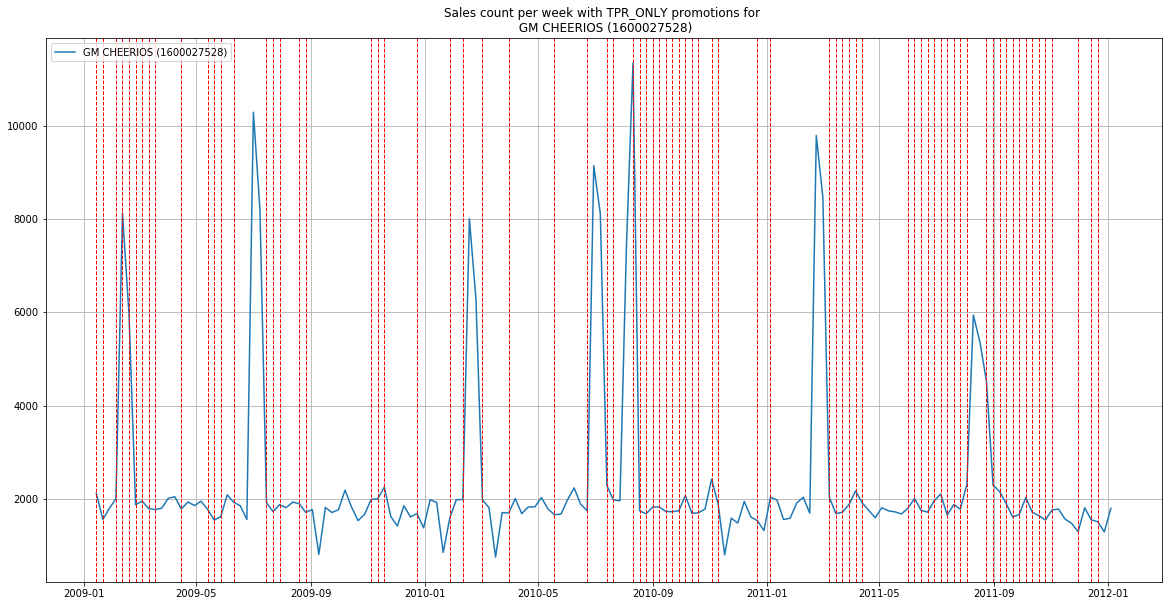

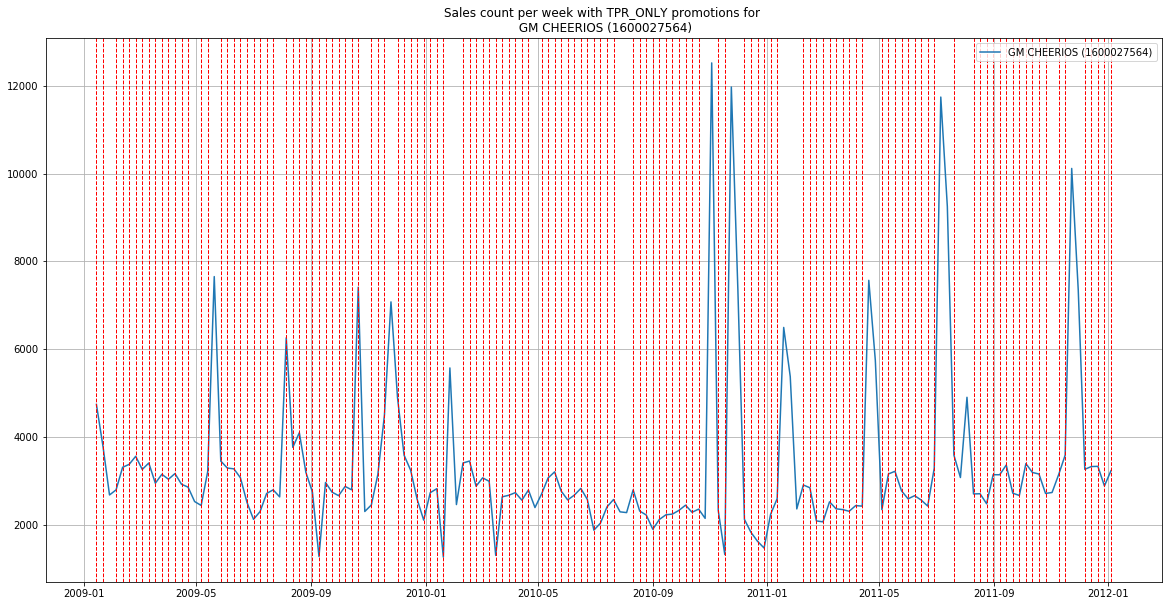

In [207]:
for column in ("FEATURE", "DISPLAY", "TPR_ONLY"):
    for ix, row in top5_prods_by_sales.iterrows():
        ax = utils.plot_salescount_per_week(
            transactions, 
            products, 
            set([ix]), 
            "Sales count per week with " + column + " promotions for \n " + row.DESCRIPTION + " (" + str(ix) + ")"
        )
        
        for dt in transactions[(transactions.UPC == ix) & (transactions[column] == 1)].WEEK_END_DATE.unique():
            plt.axvline(dt, color='r', linestyle='--', lw=1)

        plt.grid()

_**4**. Use the `fbprophet` library (available in python and R) to produce a weekly time-series forecast for the last 4 weeks of sales separately for the 5 selected products. Provide the values of your mean squared error for each product._

First we predict the weekly numbers of sold units without any hyperparameter tuning, using the default parametrization:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


UPC 1600027527: MSE = 21953887.153615944


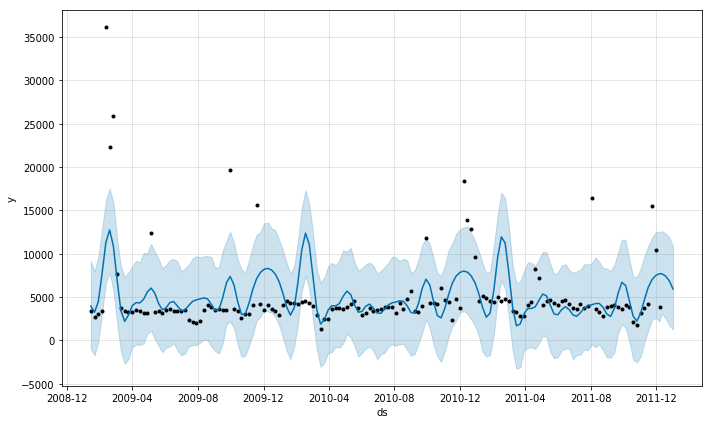

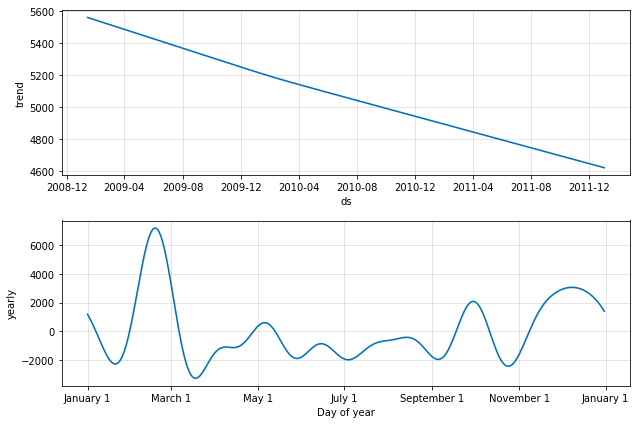

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


------------------------------
UPC 3800031838: MSE = 15290576.569986247


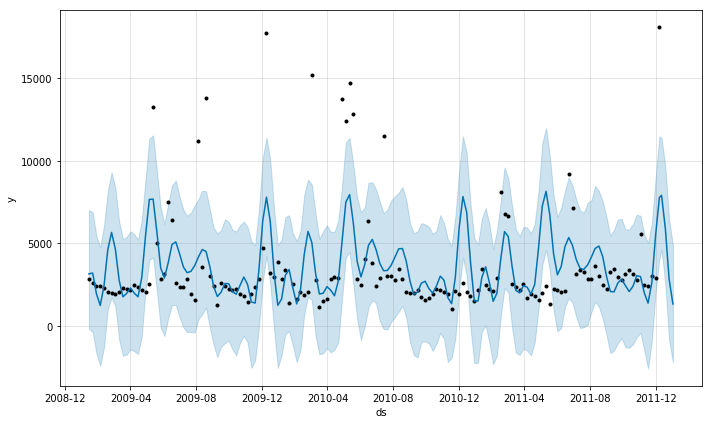

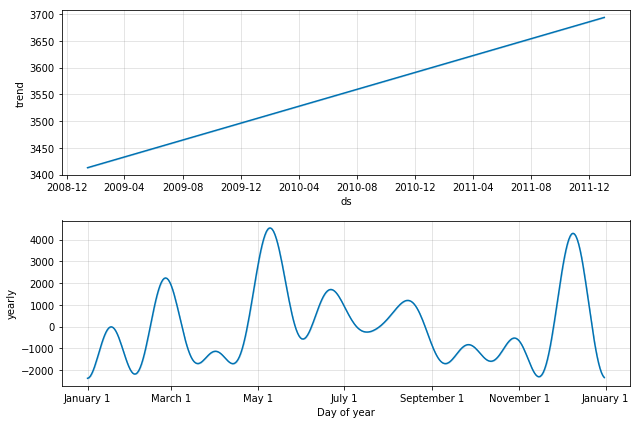

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


------------------------------
UPC 7192100339: MSE = 961826.1765078964


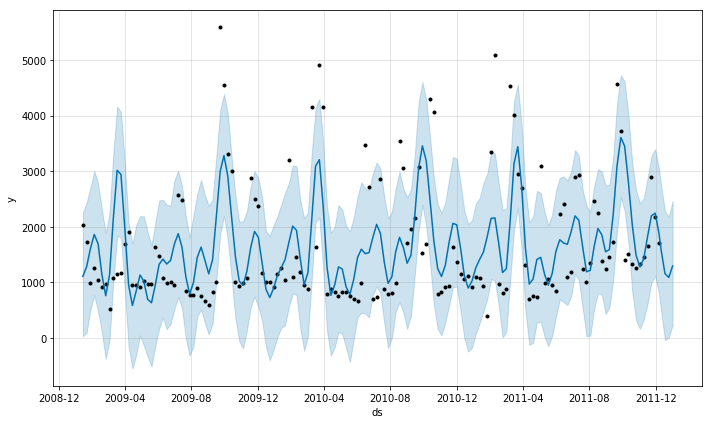

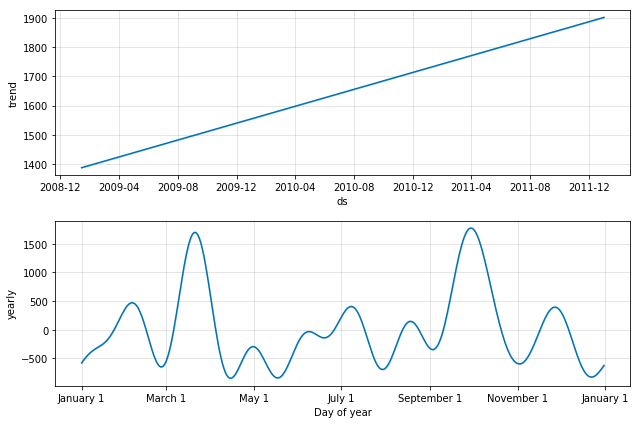

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


------------------------------
UPC 1600027528: MSE = 54134.608243813265


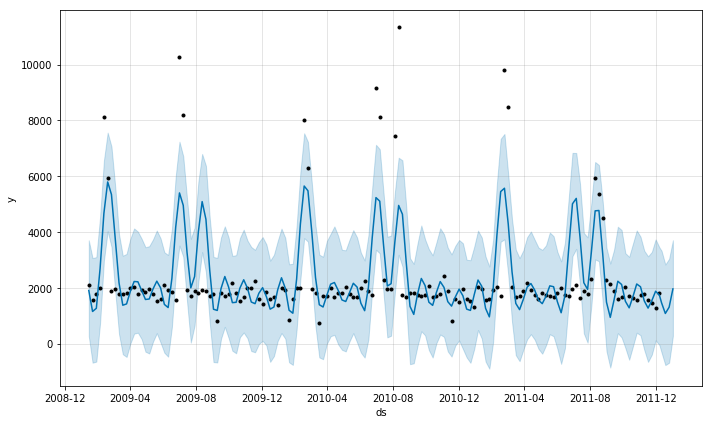

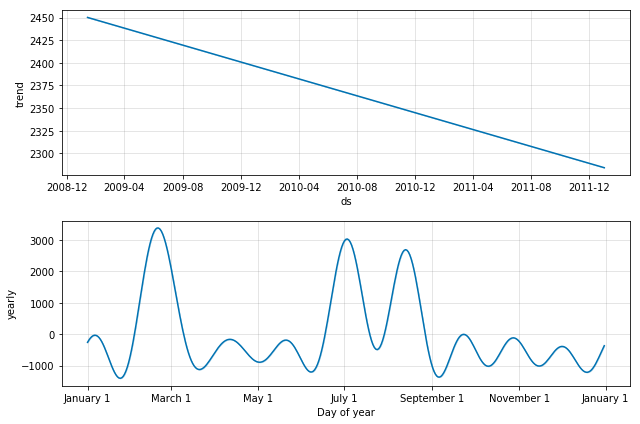

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


------------------------------
UPC 1600027564: MSE = 1664880.23678598


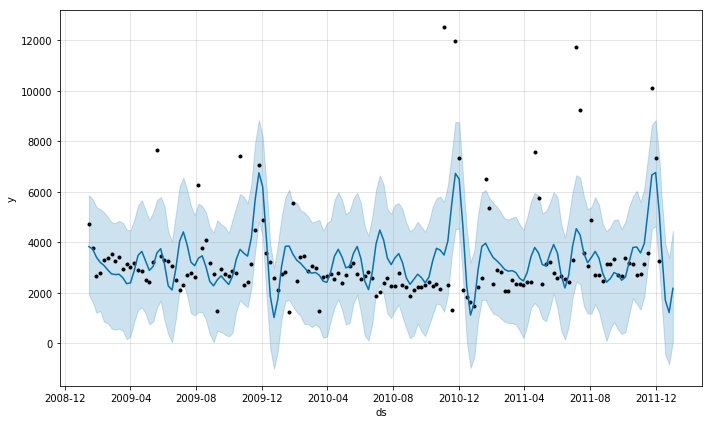

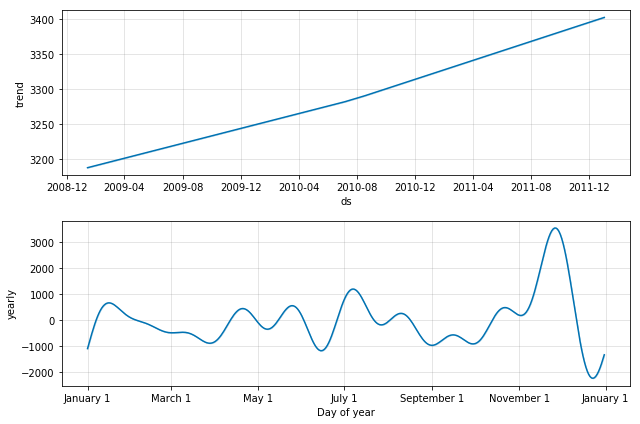

------------------------------


In [208]:
salescount_by_week = utils.compute_salescount_per_week(transactions, set(top5_prods_by_sales.index.values))

for ix in top5_prods_by_sales.index.values:
    # Split in train and test set..
    base_df = salescount_by_week.loc[ix].reset_index().rename(columns={"WEEK_END_DATE": "ds", "UNITS": "y"})
    split_date = base_df.max()["ds"] - pd.Timedelta(4, unit='w')
    train_set = base_df[base_df.ds <= split_date]
    test_set = base_df[base_df.ds > split_date]

    with utils.suppress_stdout_stderr():
        proph = Prophet()
        proph.fit(train_set)
        future = proph.make_future_dataframe(periods=4, freq="W")
        forecast = proph.predict(future)
    
    print(f"UPC {ix}: MSE = {np.mean(np.power(test_set.y - forecast.yhat.tail(4), 2))}")
    proph.plot(forecast)
    proph.plot_components(forecast)
    plt.show()
    print("-" * 30)
    

We see that while `prophet` makes some decent predictions, there is a considerable number of outliers that are bit included in it's 0.8-confidence interval. Next we apply a grid search over a limited number of hyperparameters to find an optimal parametrization for each of the products:

In [209]:
base_dfs = {
    upc: salescount_by_week.loc[upc].reset_index().rename(columns={"WEEK_END_DATE": "ds", "UNITS": "y"})
    for upc in top5_prods_by_sales.index.values
}

if not os.path.isfile("ts_gridsearch_results.pkl"):
    # Hyperparameter tuning:
    hyperparameters = [
        # yearly_seasonality
        [True, False],
        # custom monthly_seasonality
        [True, False],
        # weekly_seasonality
        [True, False],
        # daily_seasonality
        [True, False],
        # seasonality_mode
        ["additive", "multiplicative"],
        # n_changepoints
        [5, 15, 25, 35, 50],
    ]
    prophet_configs = [
        (upc, hp_config, base_dfs[upc])
        for upc in top5_prods_by_sales.index.values
        for hp_config in [
            config for config in itertools.product(*hyperparameters)
        ]
    ]

    # Hyperparameter grid search.
    with Pool(psutil.cpu_count(logical=True)) as thread_pool:
        config_results = list(
            tqdm_notebook(
                thread_pool.imap(utils.run_prophet_configuration_wrapper, prophet_configs),
                total=len(prophet_configs)
            )
        )

    ts_gridsearch_results = pd.DataFrame(config_results)
    ts_gridsearch_results.to_pickle("ts_gridsearch_results.pkl")
else:
    ts_gridsearch_results = pd.read_pickle("ts_gridsearch_results.pkl")

The three best- and worst-performing hyperparameter configurations for each UPC according to our grid search are as follows:

In [210]:
for upc in top5_prods_by_sales.index.values:
    print(top5_prods_by_sales.loc[upc].extended_description)
    print("\nBest:")
    display(ts_gridsearch_results[ts_gridsearch_results.UPC == upc].sort_values("MSE", ascending=True).head(3))
    print("\nWorst:")
    display(ts_gridsearch_results[ts_gridsearch_results.UPC == upc].sort_values("MSE", ascending=True).tail(3))
    print("-" * 30 + "\n")

GM HONEY NUT CHEERIOS (1600027527)

Best:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
26,1.254290e+07,1600027527,True,True,15,multiplicative,False,True
67,1.271513e+07,1600027527,True,False,25,multiplicative,False,True
25,1.326055e+07,1600027527,True,True,5,multiplicative,False,True



Worst:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
133,6.166421e+07,1600027527,False,False,35,additive,True,False
130,6.247539e+07,1600027527,False,False,5,additive,True,False
131,6.310371e+07,1600027527,False,False,15,additive,True,False


------------------------------

KELL FROSTED FLAKES (3800031838)

Best:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
190,1.320246e+07,3800031838,False,True,5,additive,False,True
194,1.328306e+07,3800031838,False,True,50,additive,False,True
183,1.339096e+07,3800031838,True,True,35,additive,False,True



Worst:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
295,2.968544e+08,3800031838,False,False,5,multiplicative,True,False
255,3.224435e+08,3800031838,False,True,5,multiplicative,True,False
299,3.815161e+08,3800031838,False,False,50,multiplicative,True,False


------------------------------

DIGRN PEPP PIZZA (7192100339)

Best:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
374,578682.611268,7192100339,False,False,50,additive,True,True
370,582819.576085,7192100339,False,False,5,additive,True,True
373,585225.220669,7192100339,False,False,35,additive,True,True



Worst:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
347,1.287786e+06,7192100339,True,True,25,multiplicative,False,True
346,1.302596e+06,7192100339,True,True,15,multiplicative,False,True
410,1.339364e+06,7192100339,False,True,5,additive,True,False


------------------------------

GM CHEERIOS (1600027528)

Best:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
556,39685.624362,1600027528,False,False,15,multiplicative,False,True
559,40366.651297,1600027528,False,False,50,multiplicative,False,True
548,40909.094513,1600027528,True,False,35,multiplicative,False,True



Worst:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
599,608890.136053,1600027528,False,True,50,multiplicative,False,False
591,627409.663253,1600027528,False,True,15,additive,False,False
590,646362.259143,1600027528,False,True,5,additive,False,False


------------------------------

GM CHEERIOS (1600027564)

Best:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
787,167485.521523,1600027564,True,False,25,multiplicative,False,False
799,190036.503704,1600027564,False,False,50,multiplicative,False,False
794,190036.503704,1600027564,False,False,50,additive,False,False



Worst:


,MSE,UPC,daily_seasonality,monthly_seasonality,n_changepoints,seasonality_mode,weekly_seasonality,yearly_seasonality
734,3.798290e+06,1600027564,False,True,50,additive,True,False
730,4.021652e+06,1600027564,False,True,5,additive,True,False
770,4.329362e+06,1600027564,False,False,5,additive,True,False


------------------------------



We see that different hyperparameter settings can indeed have a significant influence on the performance of a `prophet` model.
Finally, we introduce the promotion dates as _holidays_ in our models (using the best-performing configuration per UPC) and compare the results.

In [211]:
best_configs_by_upc = {
    upc: ts_gridsearch_results[ts_gridsearch_results.UPC == upc].sort_values("MSE", ascending=True).iloc[0][[
        "yearly_seasonality",
        "monthly_seasonality",
        "weekly_seasonality",
        "daily_seasonality",
        "seasonality_mode",
        "n_changepoints",
        "MSE"
    ]]
    for upc in top5_prods_by_sales.index.values
}

# Use holidays.
for upc in best_configs_by_upc:
    config = best_configs_by_upc[upc]
    result_without_holidays = utils.evaluate_prophet_configuration(
        upc,
        [
            config.yearly_seasonality,
            config.monthly_seasonality,
            config.weekly_seasonality,
            config.daily_seasonality,
            config.seasonality_mode,
            config.n_changepoints
        ],
        base_dfs[upc]
    )["MSE"]
    result_with_holidays = utils.evaluate_prophet_configuration(
        upc,
        [
            config.yearly_seasonality,
            config.monthly_seasonality,
            config.weekly_seasonality,
            config.daily_seasonality,
            config.seasonality_mode,
            config.n_changepoints
        ],
        base_dfs[upc],
        holidays=pd.concat([
            pd.DataFrame({
                'holiday': promotion_type,
                'ds': transactions[
                    (transactions.UPC == upc) & (transactions[promotion_type] == 1)
                ].WEEK_END_DATE.unique(),
                'lower_window': 0,
                'upper_window': 0,
            })
            for promotion_type in ("FEATURE", "DISPLAY", "TPR_ONLY")
        ])
    )["MSE"]

    relative_MSE_delta = (result_without_holidays - result_with_holidays) / result_without_holidays
    print(f"Delta for {top5_prods_by_sales.loc[upc].extended_description}: {relative_MSE_delta}")
    print(f"Without holidays: MSE = {result_without_holidays}, with holidays: MSE = {result_with_holidays}")
    print("-" * 30)

Delta for GM HONEY NUT CHEERIOS (1600027527): -0.8699714461101149
Without holidays: MSE = 24915903.447771467, with holidays: MSE = 46592028.00136921
------------------------------
Delta for KELL FROSTED FLAKES (3800031838): -0.058803823955005295
Without holidays: MSE = 31860228.42995649, with holidays: MSE = 33733731.693717904
------------------------------
Delta for DIGRN PEPP PIZZA (7192100339): 0.13443863625232969
Without holidays: MSE = 988210.194255078, with holidays: MSE = 855356.5634087755
------------------------------
Delta for GM CHEERIOS (1600027528): 0.7570021876202927
Without holidays: MSE = 137227.54972841227, with holidays: MSE = 33345.994382231685
------------------------------
Delta for GM CHEERIOS (1600027564): 0.09341496078402992
Without holidays: MSE = 199460.45606101828, with holidays: MSE = 180827.86538011354
------------------------------


Surprisingly, introducing promotions as holidays only yields improvements for two out of the five bestselling products; the results degraded slightly to drastically for the other three.

## 2. Machine Learning

_**1**. Select products that have been in sale for the last month._

_**2**. For each product, produce base-line predictions:_
* _sales in the previous week_
* _average weekly sales_
* _moving average weekly sales with a chosen window_

_Split the data in train and test parts. Provide the score of these base-line
predictions averaged over all products of the test set._

______________________________

For our evaluation baseline, we measure the accuracy of our predictions as MSE.

**Assumptions:**
* We separate our train from our test set in a random fashion set from the second half of the observation timeframe on on with a ratio of $0.8:0.2$.
* We understand baseline prediction algorithm #2 - "average weekly sales" - to be the average weekly sales over the whole training dataset.


In [212]:
# valid_product_ids contain all UPCs that have been bought during the last four weeks of the observation 
# timeframe.
scores = {}
datasets = {}

sales_by_week_and_upc = transactions[
    transactions.UPC.isin(valid_product_ids)
].groupby(["UPC", "WEEK_END_DATE"]).sum()[["SPEND"]]

# Prepare train and test set.
dataset = sales_by_week_and_upc.reset_index()
week_end_dates = dataset.WEEK_END_DATE.unique()
n_train = math.ceil(len(week_end_dates) * 0.8)
n_test = len(week_end_dates) - n_train
test_dates = set(np.random.choice(week_end_dates[len(week_end_dates) // 2:], n_test, replace=False))
train_dates = set(week_end_dates) - set(test_dates)
dataset = dataset.rename(columns={"WEEK_END_DATE": "ds", "SPEND": "y"})


for upc in valid_product_ids:
    base_df = dataset[dataset.UPC == upc]
    datasets[upc] = {
        "train_set": base_df[base_df.ds.isin(train_dates)],
        "test_set":  base_df[base_df.ds.isin(test_dates)]
    }
    train_set = datasets[upc]["train_set"]
    test_set = datasets[upc]["test_set"]
    
    # Compute values for prev. week baseline and rolling average baseline.
    # More efficient/vectorized way to do this?
    prev_week_spend = []
    moving_avg_values = []
    w = 4
    for ix, row in test_set.iterrows():
        prev_week_spend.append(train_set[train_set.ds < row.ds].tail(1).y.values[0])
        moving_avg_values.append(train_set[train_set.ds < row.ds].tail(w).mean().y)
    
    scores[upc] = {
        "prev_week": np.mean(np.power(test_set.y.values - np.asarray(prev_week_spend), 2)),
        "avg_weekly_sales": np.mean(np.power(test_set.y - train_set.mean().y, 2)),
        "moving_avg": np.mean(np.power(test_set.y - moving_avg_values, 2))
    }
    
# Average MSEs for baseline algorithms over all UPCs sold in the last four weeks of the observation timeframe.
display(pd.DataFrame(scores).transpose().mean())

avg_weekly_sales    5.014323e+06
moving_avg          5.784951e+06
prev_week           8.450627e+06
dtype: float64

As can be seen above, all three baselines work roughly equally well with our randomly.

_**3**. Select 2 different machine-learning algorithms and briefly describe them._

We decided to use two simple models, building on our experience that more sophisticated models should only be used when simpler models fail. Our choices:
1. Linear regression - optimizes linear weights of various features while minimizing the difference between the actual and the predicted target values.
2. Random forest - a RF is flexible and relatively performant model while offering decent accuracy with many (especially simpler) datasets. It creates an arbitrary number of decision trees, which in turn are DAGs structured to optimize a criterion (e. g. entropy) in extracting rules for estimating target variables.

We use `sklearn`'s implementation for both models.

_**4**. For each product use as features weekly sales for the previous 16 weeks to predict sales of the last week. Describe the performance of each algorithm and compare it to the performance of the best base-line prediction._

Due to the requirement of comparison to the baseline algorithms, we assume that we have to predict the sales for each week in the test set - hence we also don't use data from the test set to train our models.

In [213]:
train_df = pd.DataFrame()
training_set_filepath = "2_4_training_set.pkl"

if not os.path.isfile(training_set_filepath):
    pbar = tqdm_notebook(total=len(valid_product_ids))
    
    # Inefficient way to generate training set.
    for upc in valid_product_ids:
        base_df = dataset[dataset.UPC == upc]    
        base_train_df = base_df[base_df.ds.isin(train_dates)]

        for ix, row in base_train_df[16:].iterrows():
            observation = base_train_df[base_train_df.ds < row.ds].tail(16).pivot(index="UPC", columns="ds", values="y")
            observation.columns = [i for i in range(-1, -17, -1)]
            observation[0] = row.y
            observation["UPC"] = upc
            train_df = pd.concat([train_df, observation])

        pbar.update(1)

    observation.UPC = pd.get_dummies(observation.UPC)
    train_df.to_pickle(training_set_filepath)
else:
    train_df = pd.read_pickle(training_set_filepath)

After preparing our training dataset, we train our models (separated by product):

In [214]:
X = train_df.drop(columns=[0]).values
y = train_df[0].values
lr_model = LinearRegression().fit(X, y)
rf_model = RandomForestRegressor(n_estimators=100).fit(X, y)

Finally, we measure the performance in terms of MSE on our test set.

In [215]:
pbar = tqdm_notebook(total=len(valid_product_ids))
scores_lr = []
scores_rf = []

for upc in valid_product_ids:
    eval_set = pd.DataFrame()
    base_df = dataset[dataset.UPC == upc]    
    base_train_df = base_df[base_df.ds.isin(train_dates)]
    base_test_df = base_df[base_df.ds.isin(test_dates)]
    
    for ix, row in base_test_df.iterrows():
        # Gather last 16 values.
        observation = base_train_df[base_train_df.ds < test_date].tail(16).pivot(index="UPC", columns="ds", values="y")
        observation.columns = [i for i in range(-1, -17, -1)]
        observation[0] = row.y
        observation["UPC"] = row.UPC
        
        eval_set = pd.concat([eval_set, observation])
    
    X = eval_set.drop(columns=[0]).values
    y = eval_set[0].values
    
    scores_lr.append(np.mean(np.power(y - lr_model.predict(X), 2)))
    scores_rf.append(np.mean(np.power(y - rf_model.predict(X), 2)))
    
    pbar.update(1)

print("Average MSE for linear regression: {:.2E}".format(Decimal(np.asarray(scores_lr).mean())))
print("Average MSE for random forest: {:.2E}".format(Decimal(np.asarray(scores_rf).mean())))

#avg_weekly_sales    6.574280e+06
#moving_avg          7.906424e+06
#prev_week           7.793444e+06

Average MSE for linear regression: 5.58E+6
Average MSE for random forest: 6.50E+6


Somewhat surprisingly, both models are beaten (although not by much) by the best baseline. We assume that they (1) are too simple to utilize seasonality in the dataset and (2) don't capture outliers well enough, which is, as we have seen in task **1**, also a problem for `prophet`.

_**5**. To increase the size of the data-set and make use of the seasonality we adopt a rolling-window strategy with a lag of 16 weeks. The idea is:_
* _For each product use the values Xt+1; : : : ; Xt+16 as features and Xt+17 as a target for all possible t ≥ 0 (in this way the data-set will contain more multiple samples per product)._
* _Add date related features like year, month, and week number of the target Xt+17._
* _Add aggregated features like total, mean, median, standard deviation of the sales for each row._
* _Add product related features from the product-lookup sheet. Use category encoding if needed._
* _If possible use other columns to generate new features: HHS (housholds that bought the product) or STORE NUM._
_How adding new features influenced the performance of your algorithms?_
* _Choose a feature selection algorithm and describe briefly what it does. Try to use it on the features that you engineered and describe if it influenced the performance of the algorithms._

We decide to use the total number of households (not distinct, since we can't access that information) and the number of visits as attributes additional to the statistics and the actual values of the last 16 weeks.

In [216]:
# Generate training dataset.

train_df = pd.DataFrame()
training_set_filepath = "2_5_training_set.pkl"
transactions_metadata = transactions.groupby(
    ["WEEK_END_DATE", "UPC"]
).sum()[["HHS", "VISITS"]].reset_index().rename(columns={"WEEK_END_DATE": "ds"})
extended_dataset = dataset.merge(transactions_metadata, on=["ds", "UPC"])

if not os.path.isfile(training_set_filepath):
    pbar = tqdm_notebook(total=len(valid_product_ids))
    
    # Inefficient way to generate training set.
    for upc in valid_product_ids:
        base_df = extended_dataset[extended_dataset.UPC == upc]

        for ix, row in base_df[16:].iterrows():
            observation = base_df[base_df.ds < row.ds].tail(16).pivot(index="UPC", columns="ds", values="y")
            val_col_names = [i for i in range(-1, -17, -1)]
            observation.columns = val_col_names
            observation[0] = row.y
            
            observation["year"] = row.ds.year
            observation["month"] = row.ds.month
            observation["week"] = row.ds.week
            
            t16_values = observation[val_col_names]
            observation["total"] = t16_values.values.sum()
            observation["mean"] = t16_values.values.mean()
            observation["median"] = np.median(t16_values.values)
            observation["std"] = np.std(t16_values.values)
            
            prod = products.loc[upc]
            observation["CATEGORY"] = prod.CATEGORY
            observation["MANUFACTURER"] = prod.MANUFACTURER
            observation["SUB_CATEGORY"] = prod.SUB_CATEGORY
            
            observation["HHS"] = row.HHS
            observation["VISITS"] = row.VISITS
            
            train_df = pd.concat([train_df, observation])
 
        pbar.update(1)

    # Encode categorical variables.
    categorical_cols = ["CATEGORY", "MANUFACTURER", "SUB_CATEGORY"]
    dummies = pd.get_dummies(train_df[categorical_cols])
    train_df = pd.concat([train_df.drop(columns=categorical_cols), dummies], axis=1)
    train_df.to_pickle(training_set_filepath)
else:
    train_df = pd.read_pickle(training_set_filepath)

We train our models on the new dataset:

In [217]:
X = train_df.drop(columns=[0]).values
y = train_df[0].values
lr_model = LinearRegression().fit(X, y)
rf_model = RandomForestRegressor(n_estimators=100).fit(X, y)

We evaluate our models trained on the extended dataset.

In [218]:
pbar = tqdm_notebook(total=len(valid_product_ids))
scores_lr = []
scores_rf = []

for upc in valid_product_ids:
    base_df = train_df.loc[upc]
    X = base_df.drop(columns=[0]).values
    y = base_df[0].values
    
    scores_lr.append(np.mean(np.power(y - lr_model.predict(X), 2)))
    scores_rf.append(np.mean(np.power(y - rf_model.predict(X), 2)))
    
    pbar.update(1)

print("Average MSE for linear regression: {:.2E}".format(Decimal(np.asarray(scores_lr).mean())))
print("Average MSE for random forest: {:.2E}".format(Decimal(np.asarray(scores_rf).mean())))

#avg_weekly_sales    6.574280e+06
#moving_avg          7.906424e+06
#prev_week           7.793444e+06

Average MSE for linear regression: 7.93E+5
Average MSE for random forest: 5.72E+4


Apparently adding additional columns* had a drastic effect on model performance: Our MSE decresed by an order of magnitude from ~ $5 \cdot 10^6$ to ~ $5 \cdot 10^4$, beating both our baseline and reference models (i. e. linear regression and random forest with only sales number from the last 16 weeks).  
Note that, like specified in the task description, we also changed how the test set is built. We thereby predict on the training set, which can also be an influence in improving the model.

Finally, we choose _univariate feature selection_ as feature selection algorithm and try to evaluate how important which features are. We consider that sufficient as a first approximation since we want to evaluate the contribution of individual columns.

,mutual_information_score
VISITS,1.790990e+00
HHS,1.762278e+00
-16,3.537346e-01
median,2.417853e-01
mean,2.344332e-01
total,2.344189e-01
std,2.054355e-01
-15,2.006447e-01
week,1.935984e-01
-13,1.688566e-01


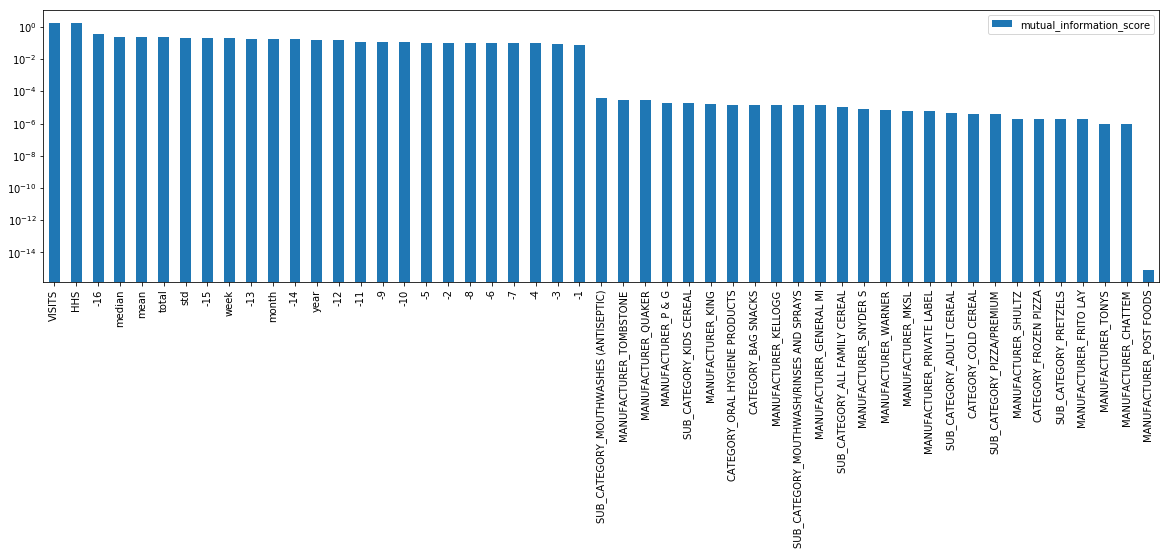

In [219]:
pbar = tqdm_notebook(total=len(valid_product_ids))
feature_scores = []

for upc in valid_product_ids:
    base_df = train_df.loc[upc]
    feature_scores.append(mutual_info_regression(base_df.drop(columns=[0]).values, base_df[0].values))
    pbar.update(1)

# Average feature_scores over all UPCs in set, sort results.
df = pd.DataFrame(
    [np.asarray(feature_scores).mean(axis=0)], 
    columns=train_df.drop(columns=[0]).columns.values
).transpose().rename(
    columns={0: "mutual_information_score"}
).sort_values("mutual_information_score", ascending=False)

display(df)
df.plot.bar(figsize=(20, 5), logy=True)

As the table and plot (note that it's a logarithmic axis) above show, the most recently added columns representing the number of buying households and the number of visits have the greatest correlation/mutul information with the actual number of sales, followed, with dramatically less significance, by the statistical measures on the last 16 weeks and the actual numbers from the last 16 weeks. The type of product seems to make little to no difference.